# Rolling Planning mit Lateness (Tardiness + Earliness)

In [1]:
max_time = 60*60*1 # 1h

In [2]:
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 26)

import utils.scheduling_solver as ssv
import utils.rescheduling_solver as rssv

import utils.presenter as show
import utils.checker as check


import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced
import utils.schedule_deadline as deadline_gen

from ProductionDaySimulation import ProductionDaySimulation

load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\re2.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\highs.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\ortools.dll...


In [3]:
file_template = "data/05_{text}.csv"

## Generierung des Datensatzes für 20 Tage (Ankunft)

In [4]:
days_numb = 20

In [5]:
df_instance = pd.read_csv("data/00_instance.csv")

df_ops, df_jobs = rp_init.init_jobs_with_arrivals(df_instance, days_numb,  u_b_mmax = 0.92)
df_ops

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
3795,Job_379,5,M9,76
3796,Job_379,6,M5,47
3797,Job_379,7,M3,52
3798,Job_379,8,M4,90


In [6]:
# a) Initialisierung der Deadlines
df_jobs = deadline_gen.get_times_df(df_ops, df_jobs, ssv.schedule_fcfs_with_arrivals, target_service=1.0)

# Rundung für CP 
df_jobs["Arrival"] = np.floor(df_jobs["Arrival"]).astype(int)
df_jobs["Deadline"] = np.ceil(df_jobs["Deadline"]).astype(int)
df_jobs.head()

,Job,Arrival,Deadline
0,Job_000,0,1158
1,Job_001,86,1581
2,Job_002,149,1815
3,Job_003,203,2124
4,Job_004,241,1393


In [7]:
# b) Bestimmung der "Ready Time"
df_jobs['Ready Time'] = ((df_jobs['Arrival'] // 1440) + 1) * 1440

# c) Processing Time
processing_time = df_ops.groupby('Job')['Processing Time'].sum()
df_jobs = pd.merge(df_jobs, processing_time, on='Job')

# d) Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])

# e) Anpassung der Deadlines
min_slack = df_jobs['Slack'].min()

if min_slack < 180:
    extra_time = abs(min_slack) + 180 if min_slack < 0 else 180
    print(f"Der bisherige min. Slack: {min_slack}")
    df_jobs["Deadline"] = df_jobs["Deadline"] + extra_time

# f) erneute Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])
df_jobs 

Der bisherige min. Slack: -677


,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,2015,1440,395,180
1,Job_001,86,2438,1440,510,488
2,Job_002,149,2672,1440,568,664
3,Job_003,203,2981,1440,655,886
4,Job_004,241,2250,1440,393,417
...,...,...,...,...,...,...
375,Job_375,28525,31302,28800,655,1847
376,Job_376,28531,30541,28800,393,1348
377,Job_377,28532,31055,28800,568,1687
378,Job_378,28655,30670,28800,395,1475


In [8]:
df_jobs['Slack'].mean()

np.float64(1123.4736842105262)

In [9]:
df_jobs['Slack'].max()

1859

In [10]:
file = file_template.format(text= "all_jobs")
df_jobs.to_csv(file, index = False)

file = file_template.format(text= "all_ops")
df_ops.to_csv(file, index = False)

### Params

In [11]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


> Tag 0 wird nicht ausgeführt

## Tag 1 (init. Tag - kein Rescheduling)

In [12]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [13]:
# aktuelle Produktionaufträge
df_jobs_curr, df_ops_curr = rp_proced.filter_ops_and_jobs_by_ready_time(df_jobs, df_ops, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,2015,1440,395,180
1,Job_001,86,2438,1440,510,488
2,Job_002,149,2672,1440,568,664
3,Job_003,203,2981,1440,655,886
4,Job_004,241,2250,1440,393,417
5,Job_005,312,2624,1440,496,688
6,Job_006,351,2429,1440,416,573
7,Job_007,504,2942,1440,539,963
8,Job_008,731,3339,1440,597,1302
9,Job_009,764,3205,1440,540,1225


### A) Scheduling

In [14]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_cp_jssp_lateness_by_tardiness_and_earliness(df_ops_curr, df_jobs_curr, w_t = 5,
                                                                schedule_start = 1440,
                                                                msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Objective Value       : 35.00
Best Objective Bound  : 35.00
Laufzeit              : 0.11 Sekunden

Scheduling-Dauer: 0 Minuten und 0.13 Sekunden.


,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,2015,1440,29,1469,-546,0,546
1,Job_004,0,M2,241,2250,1440,14,1454,-796,0,796
2,Job_006,0,M1,351,2429,1440,46,1486,-943,0,943
3,Job_005,0,M2,312,2624,1454,84,1538,-1086,0,1086
4,Job_001,0,M0,86,2438,1469,43,1512,-926,0,926
...,...,...,...,...,...,...,...,...,...,...,...
185,Job_013,9,M7,1160,3471,3446,25,3471,0,0,0
186,Job_011,9,M8,924,3531,3457,74,3531,0,0,0
187,Job_016,9,M4,1172,3695,3662,33,3695,0,0,0
188,Job_018,9,M7,1398,3839,3794,45,3839,0,0,0


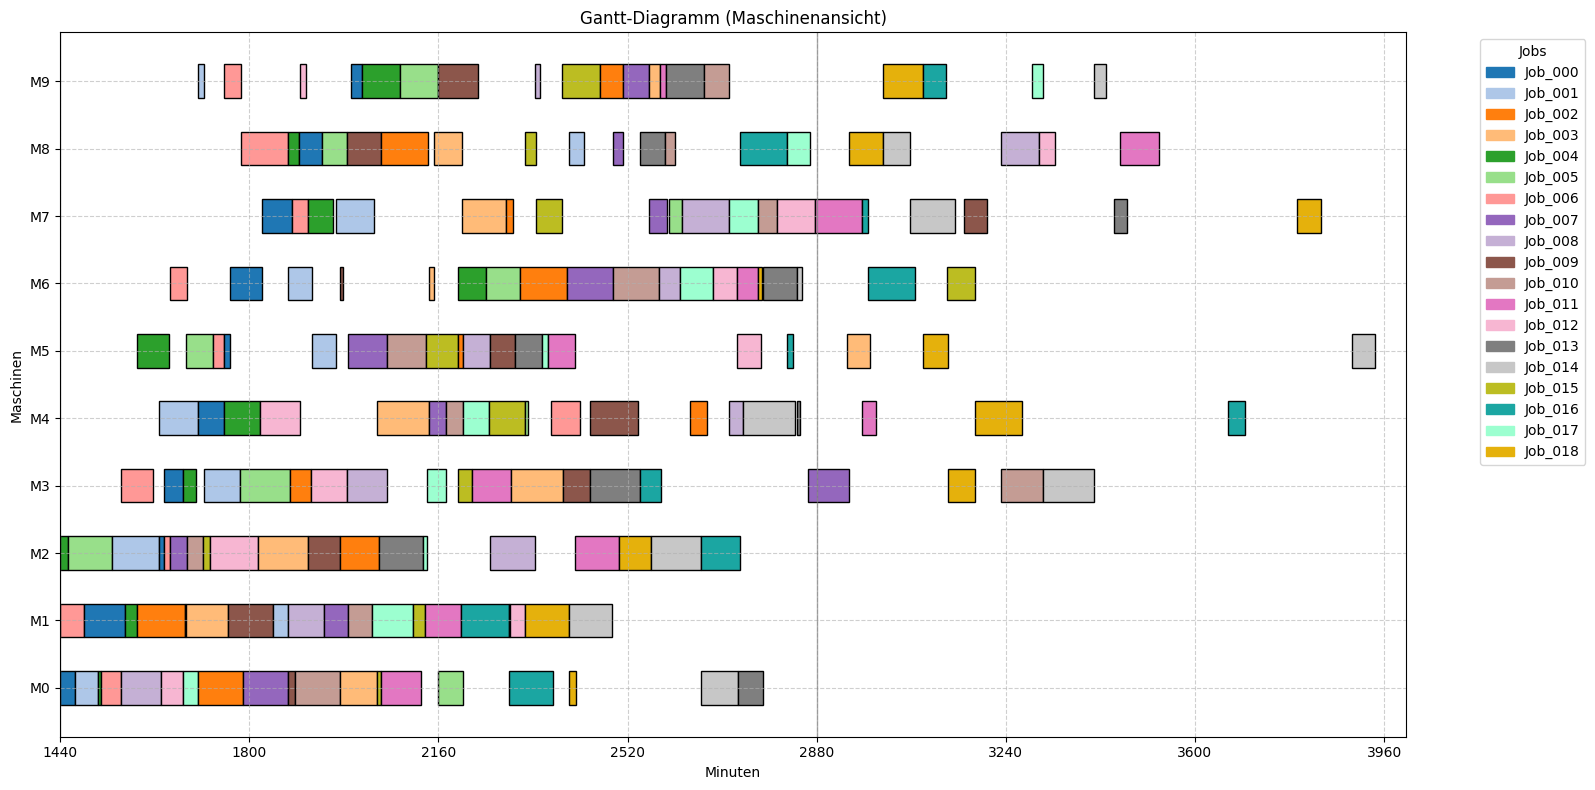

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [15]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [16]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         1
0              18
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64


In [17]:
file = file_template.format(text= f"plan_{day_numb:02d}_init")
file

'data/05_plan_01_init.csv'

In [18]:
df_plan.to_csv(file, index = False)

### B) Aufteilung in heutige und zukünftge Operationen

In [19]:
df_plan_for_sim = rp_proced.filter_plan_for_today(df_plan, latest_op_start = day_end)
df_plan_for_sim

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,2015,1440,29,1469,-546,0,546
1,Job_000,7,M7,0,2015,1825,56,1881,-134,0,134
2,Job_000,6,M6,0,2015,1763,62,1825,-190,0,190
3,Job_000,9,M9,0,2015,1994,21,2015,0,0,0
4,Job_000,5,M5,0,2015,1752,11,1763,-252,0,252
...,...,...,...,...,...,...,...,...,...,...,...
160,Job_017,6,M6,1295,3310,2620,62,2682,-628,0,628
161,Job_018,3,M6,1398,3839,2768,7,2775,-1064,0,1064
162,Job_018,2,M2,1398,3839,2504,61,2565,-1274,0,1274
163,Job_018,1,M0,1398,3839,2409,13,2422,-1417,0,1417


In [20]:
df_plan_waiting = rp_proced.filter_plan_for_future(df_plan, earliest_op_start = day_end)
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_003,9,M5,203,2981,2938,43,2981,0,0,0
1,Job_008,9,M8,731,3339,3230,74,3304,-35,0,35
2,Job_009,9,M7,764,3205,3160,45,3205,0,0,0
3,Job_010,9,M3,872,3310,3231,79,3310,0,0,0
4,Job_011,8,M4,924,3531,2966,26,2992,-539,0,539
5,Job_011,9,M8,924,3531,3457,74,3531,0,0,0
6,Job_012,9,M8,981,3334,3304,30,3334,0,0,0
7,Job_013,9,M7,1160,3471,3446,25,3471,0,0,0
8,Job_014,5,M8,1165,3942,3006,52,3058,-884,0,884
9,Job_014,6,M7,1165,3942,3058,85,3143,-799,0,799


In [21]:
file = file_template.format(text= f"plan_{day_numb:02d}_waiting")
file

'data/05_plan_01_waiting.csv'

In [22]:
df_plan_waiting.to_csv(file, index = False)

### C) Simulation

In [23]:
simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.25)
df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job_000 started on M0
[24:00:00] Job_004 started on M2
[24:00:00] Job_006 started on M1
[24:16:31] Job_000 finished on M0 (after 16 minutes 32 seconds)
[24:17:31] Job_004 finished on M2 (after 17 minutes 31 seconds)
[24:17:31] Job_005 started on M2
[24:29:00] Job_001 started on M0
[24:36:56] Job_006 finished on M1 (after 36 minutes 56 seconds)
[24:46:00] Job_000 started on M1
[25:06:22] Job_001 finished on M0 (after 37 minutes 22 seconds)
[25:12:00] Job_004 started on M0
[25:19:58] Job_004 finished on M0 (after 07 minutes 58 seconds)
[25:19:58] Job_006 started on M0
[25:44:55] Job_005 finished on M2 (after 87 minutes 24 seconds)
[25:44:55] Job_001 started on M2
[25:53:26] Job_006 finished on M0 (after 33 minutes 28 seconds)
[25:55:00] Job_008 started on M0
[25:55:00] Job_006 started on M3
[26:23:54] Job_000 finished on M1 (after 97 minutes 54 seconds)
[26:23:54] Job_004 started on M1
[26:43:06] Job_004 finished on M1 (after 19 minutes 13 seconds)
[26:43:06] Job_002 started o

In [24]:
df_execution

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,0,0,M0,1440.00,16.53,1456.53,1456.53
1,Job_000,1,0,M1,1486.00,97.90,1583.90,1583.90
2,Job_000,2,0,M2,1653.44,14.62,1668.06,1668.06
3,Job_000,3,0,M3,1668.06,24.14,1692.20,1692.20
4,Job_000,4,0,M4,1769.95,56.38,1826.33,1826.33
...,...,...,...,...,...,...,...,...
155,Job_017,8,1295,M8,2824.00,35.80,1564.80,2859.80
156,Job_018,0,1398,M1,2471.34,66.79,1140.13,2538.13
157,Job_018,1,1398,M0,2538.13,9.47,1149.60,2547.60
158,Job_018,2,1398,M2,2547.60,81.97,1231.57,2629.57


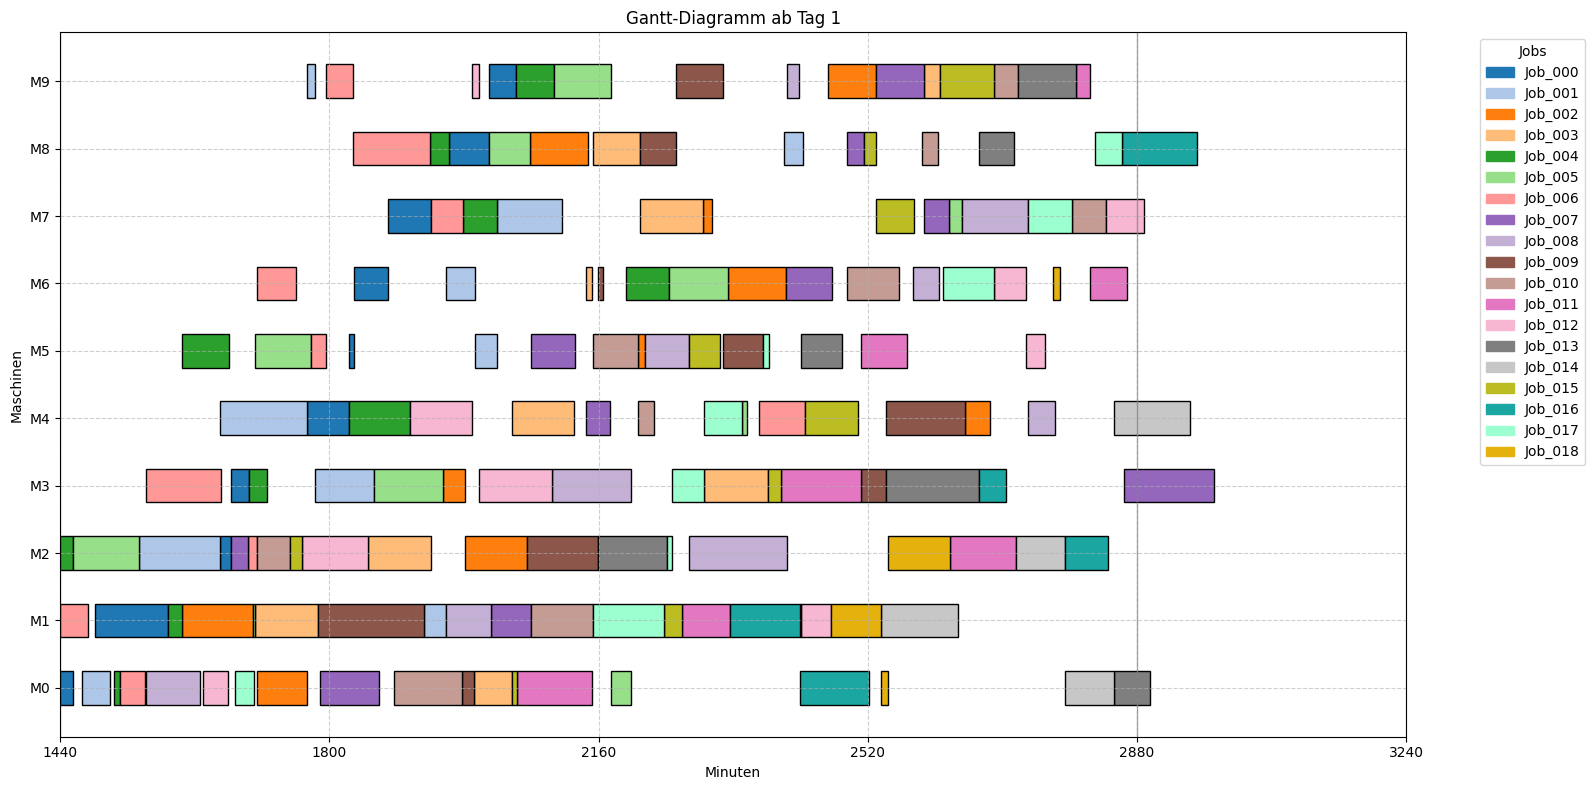

In [25]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [26]:
df_plan_undone

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
110,Job_011,7,M7,924,3531,2877,89,2966,-565,0,565
128,Job_013,7,M6,1160,3471,2778,65,2843,-628,0,628
129,Job_013,8,M4,1160,3471,2843,6,2849,-622,0,622
135,Job_014,4,M6,1165,3942,2843,9,2852,-1090,0,1090
148,Job_016,5,M5,1172,3695,2824,10,2834,-861,0,861


In [27]:
undone_numb = len(df_plan_undone)
print(f"Number of undone operations: {undone_numb}")

Number of undone operations: 5


In [28]:
file = file_template.format(text= f"execution_{day_numb:02d}")
file

'data/05_execution_01.csv'

In [29]:
df_execution.to_csv(file, index = False)

In [30]:
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
file

'data/05_plan_01_undone.csv'

In [31]:
df_plan_undone.to_csv(file, index = False)